## In this notebook we demonstrate how to read in data on developer contributions to specific repos as a bipartite matrix, and how to project this matrix onto a network of collaboration ties between developers. We focus on contributions made in 2021.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('../preprocessed/contributions.csv')

In [3]:
df.tail()

,timestamp,repo_id,user_id,repo_name,nb_commits
1654032,2022-09-01,52460,116610,GitHub/nekodjin/jace,1
1654033,2022-09-01,52463,61950,GitHub/opengirok/ogk,1
1654034,2022-09-01,52463,146261,GitHub/opengirok/ogk,1
1654035,2022-09-01,52463,146262,GitHub/opengirok/ogk,35
1654036,2022-09-01,52465,143854,GitHub/Mr-Owllers/green-tea,6


In [4]:
df_2021=df[df['timestamp'].str.contains('2021-')]

In [5]:
repo_user_n_commits_2021=df_2021.groupby(['repo_id','user_id']).nb_commits.sum().reset_index()
repo_user_n_commits_2021['repo_id']=repo_user_n_commits_2021['repo_id'].map(lambda x: str(x)+'_repo')
repo_user_n_commits_2021['user_id']=repo_user_n_commits_2021['user_id'].map(lambda x: str(x)+'_user')

In [6]:
repo_user_n_commits_2021.head()

,repo_id,user_id,nb_commits
0,1_repo,22994_user,70
1,1_repo,120063_user,6
2,1_repo,120064_user,58
3,4_repo,106434_user,8
4,4_repo,109816_user,56


In [7]:
#for convenience, let us filter repo-user pairs with at least 10 commits.
repo_user_n_commits_2021=repo_user_n_commits_2021[repo_user_n_commits_2021['nb_commits']>=10]

### Now we create a NetworkX graph from the data. The network will be bipartite with weighted edges connected users and repos. Weights indicate a count of commits.

In [8]:
B = nx.Graph()
B.add_weighted_edges_from(repo_user_n_commits_2021.values)

### We map this network to a rectangular matrix in which the rows are repos, columns are users, and the values are the number of commits. Note we use a sparse matrix representation. We also sort the matrix rows and columns by degree, then plot the matrix.

In [9]:
nodes_by_degree=sorted(nx.degree(B),key=lambda x: x[1],reverse=True)

In [10]:
mat=nx.bipartite.biadjacency_matrix(B,weight=None,
                                    row_order=[x[0] for x in nodes_by_degree if 'repo' in x[0]],
                                   column_order=[x[0] for x in nodes_by_degree if 'user' in x[0]])
mat

<18320x16888 sparse matrix of type '<class 'numpy.int64'>'
	with 34635 stored elements in Compressed Sparse Row format>

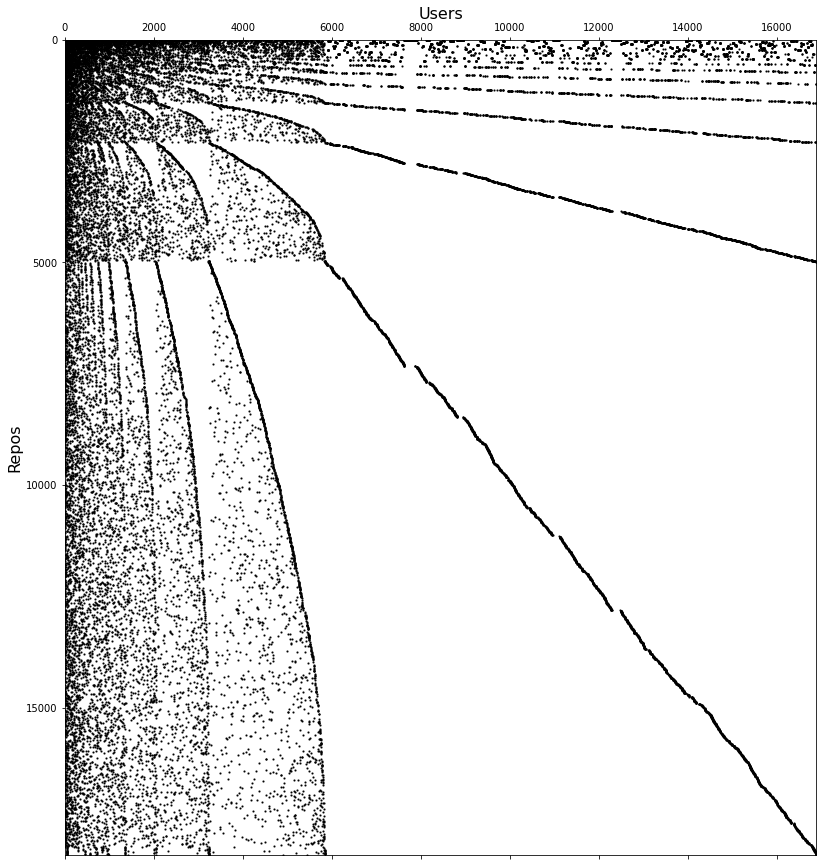

In [11]:
f,ax=plt.subplots(figsize=(15,15))
ax.spy(mat,color='black', markersize=1)
plt.xlabel('Users',size=16)
ax.xaxis.set_label_position('top') 
plt.ylabel('Repos',size=16)
plt.show()

### We can also consider only those developers contributing to at least 2 repos, and those repos with at least two contributing developers.

In [12]:
B2 = nx.subgraph(B,[x for x in B.nodes() if nx.degree(B,x)>=2])
B2 = nx.subgraph(B2,max(nx.connected_components(B2), key=len))


In [13]:
nodes_by_degree2=sorted(nx.degree(B2),key=lambda x: x[1],reverse=True)

mat2=nx.bipartite.biadjacency_matrix(B2,weight=None,
                                    row_order=[x[0] for x in nodes_by_degree2 if 'repo' in x[0]],
                                    column_order=[x[0] for x in nodes_by_degree2 if 'user' in x[0]])
mat2

<3705x3984 sparse matrix of type '<class 'numpy.int64'>'
	with 12293 stored elements in Compressed Sparse Row format>

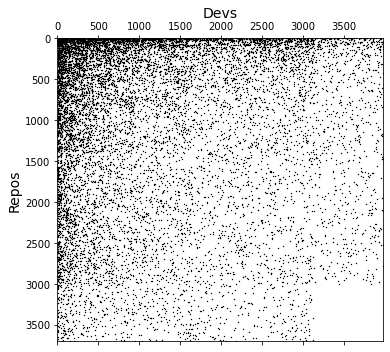

In [14]:
f,ax=plt.subplots(figsize=(6,5))
ax.spy(mat2,color='black', markersize=.4)
plt.xlabel('Devs',size=14)
ax.xaxis.set_label_position('top') 
plt.ylabel('Repos',size=14)
plt.tight_layout()
plt.show()

### Finally we project this network onto the users/developers, creating a network of developers who are connected if the contribute to the same repo. We weigh edges by the count of repos two developers work on together. 

Scientific collaboration networks: II. Shortest paths, weighted networks, and centrality, M. E. J. Newman, Phys. Rev. E 64, 016132 (2001).

In [15]:
G=nx.bipartite.weighted_projected_graph(B,nodes=[x for x in B.nodes() if 'user' in x])

In [16]:
print(nx.info(G))

Graph with 16888 nodes and 352565 edges


In [17]:
#focusing on the giant connected component:
Gcc= nx.subgraph(G,max(nx.connected_components(G), key=len))
print(nx.info(Gcc))

Graph with 9502 nodes and 339847 edges


### This is a large network. We can filter it for stronger collaborations: those pairs of nodes that work together on at least three repos.

In [18]:
strong_collaborations = nx.Graph()
strong_collaborations.add_edges_from([(n1,n2) for n1,n2,weight in Gcc.edges(data=True) if weight['weight']>=3])
print(nx.info(strong_collaborations))

Graph with 646 nodes and 1863 edges


### Let us visualize the giant connected component of this network.

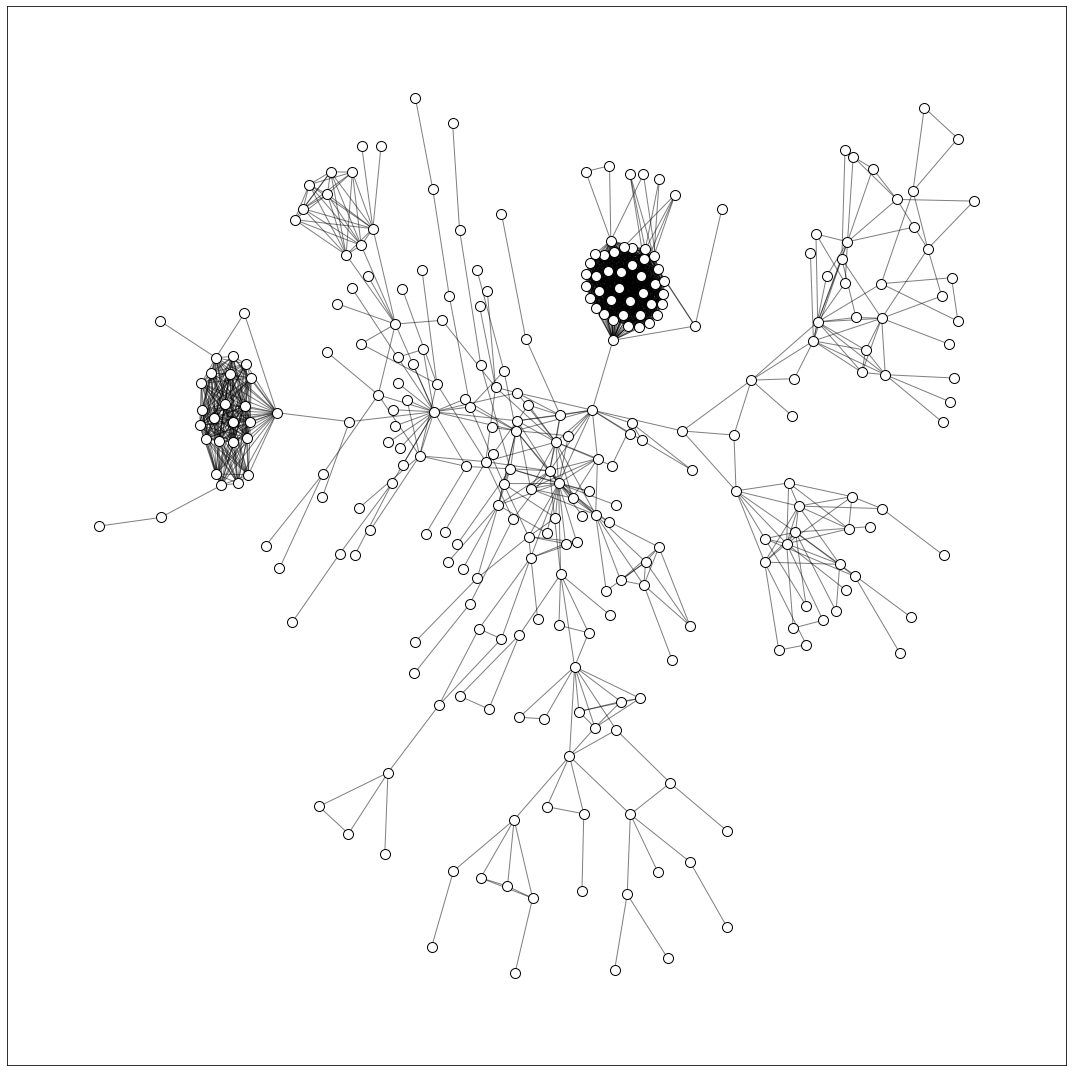

In [19]:
strong_collaborations_gcc= nx.subgraph(strong_collaborations,
                                       max(nx.connected_components(strong_collaborations), key=len))


plt.figure(figsize=(15,15))
pos = nx.drawing.nx_agraph.graphviz_layout(strong_collaborations_gcc,prog='neato')

nx.draw_networkx_edges(strong_collaborations_gcc,pos=pos,edge_color='black',width=1,alpha=.5)
nx.draw_networkx_nodes(strong_collaborations_gcc, pos, node_size=100,node_color='white',
                           linewidths=1, alpha=1,edgecolors='black')

plt.tight_layout()
plt.show()